# setup and imports

In [1]:
import fnmatch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from ipywidgets import interactive
import numpy as np
import os
import glob
from scipy.ndimage import gaussian_filter as smooth
import platform

%run sessionlists
from VIGOR_utils import *
from VIGOR_plotting import *
from VIGOR_MODELS_Functions import *

plt.style.use('./Figures/paper.mplstyle')

In [2]:
#### Define folder with data 
if platform.system()=='Linux':
    root="/home/david/Desktop/ALLDATA"
    savePath="/home/david/Desktop/Save"
elif platform.system()=='Darwin':
    root="/Users/tom/Desktop/DATA"
    savePath="/Users/tom/Desktop/Save"
if 'COLAB_GPU' in os.environ:
    !gdown --id 1BSepSzm1-KQJlUvv8C23p_qyHvtzvrZ8
    !unzip -qq /content/code/sequencesALLDATA.zip
    root="/content/code/sequencesALLDATA"
    savePath="/content/Save"
    print("I'm running on Colab")
print("Path to data is: %s"%root)

retval = os.getcwd()
print("Current working directory: %s" % retval)
print("Save Path: ", savePath)

print(f'Found {len(glob.glob(root+"/*"))} rats in the data folder')

Path to data is: /home/david/Desktop/ALLDATA
Current working directory: /home/david/Desktop/code
Save Path:  /home/david/Desktop/Save
Found 34 rats in the data folder


In [3]:
rat_markers = {}
sequence = {}

# define brain status (lesion/CNO/intact) for each rat, used in plots
# needs to be properly implemented, setting is in behav_params for each session.
brainstatus = {'RatF00': 'normal', 'RatF01': 'normal', 'RatF02': 'normal',
               'RatM00': 'normal', 'RatM01': 'normal', 'RatM02': 'normal',
               'RatF32': 'normal', 'RatF33': 'normal',
               'RatM31': 'normal', 'RatM32': 'normal',
                'RatF42': 'normal', 'RatM40': 'normal', 'RatM43': 'normal',
                'RatF50': 'DMS', 'RatF51': 'DLS', 'RatF52': 'DLS',
               'RatM50': 'DMS', 'RatM51': 'DMS', 'RatM52': 'DLS', 'RatM53': 'normal', 'RatM54': 'normal'}

markers = {'normal': 'o', 'thcre': 'd', 'lesion': 'x', 'biglesion': 'X'}
lines = {'normal': '-', 'thcre': '--', 'lesion': ':', 'biglesion': '-.'}

# define list of rats to be analyzed

# INTACT RATS
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43', 
            'RatM53', 'RatM54']


for index, animal in enumerate(animalList):
    print(f'Loading data for {animal}')
    # define marker and color for each rat, used in plots
    if fnmatch.fnmatch(animal, 'RatF*'):
        rat_markers[animal]=['silver', 'o', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'RatM*'):
        rat_markers[animal]=['silver', 'o', lines[brainstatus[animal]]]
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$",]
    else:
        print("error, this is not a rat you got here")

    if animal == 'RatM00':
        rat_markers[animal][0] = 'dodgerblue'
        
    for session in sorted(matchsession(animal, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20)):

        biglesion = True if 'L' in session else False
        sequence[animal, session] = get_from_pickle(root, animal[0:6], session, name="sequence.p", biglesion=biglesion)

 

Loading data for RatF00
Loading data for RatF01
Loading data for RatF02
Loading data for RatM00
Loading data for RatM01
Loading data for RatM02
Loading data for RatF32
Loading data for RatF33
Loading data for RatM31
Loading data for RatM32
Loading data for RatF42
Loading data for RatM40
Loading data for RatM43
Loading data for RatM53
Loading data for RatM54


In [4]:
def round_nearest(x, a=0.04):
    return np.around(x / a) * a

def generate_running_time(loc, scale, N=1, seed=0):
    u = np.random.uniform(0, 1, int(N))
    res = (np.tan(np.pi * (u - 0.5)) * scale) + loc
    res = res[res > 0.75]

    # # replace any of the values tha are below 0.5
    # # with the corresponding value above 0.5
    # for i in range(len(res)):
    #     if res[i] < 0.5:
    #         res[i] = generate_running_time(loc, scale, N=1)

    return round_nearest(res)

def generate_running_time(loc, scale, N=1, seed=0):
    np.random.seed(seed=seed)
    res = stats.cauchy.rvs(loc, scale, size=int(N))
    res = res[res > 0.75]
    # res = round_nearest(res)
    return res

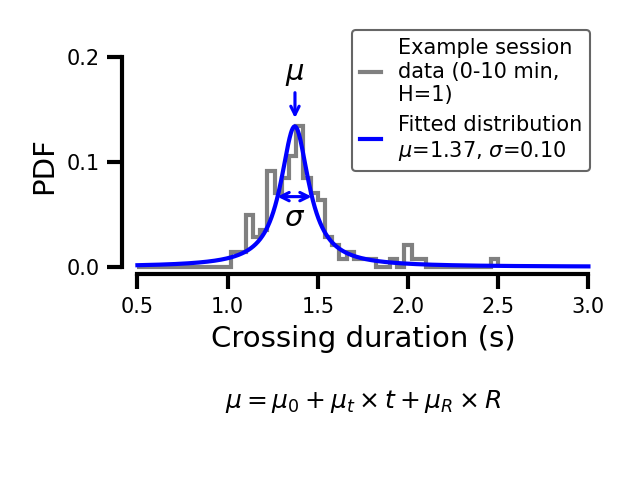

In [5]:
# crssing time first 10 min, all reward history pooled

def plot_mu(ax=None):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    animal='RatM00'
    session='RatM00_2021_07_22_16_13_03'

    crossingtimes = prepare_data_running_times(sequence, [animal], [session])
    # crossingtimes = crossingtimes[animal][0][0]
    crossingtimes = [item for sublist in prepare_data_running_times(sequence, [animal], [session])[animal][0] for item in sublist]
    
    bins=np.linspace(0.5, 2.5, 51)
    ydata, xdata, _ = ax.hist(crossingtimes, bins=bins,
                    color='gray', zorder=5, lw=1,
                    #density=True,
                    weights=np.ones_like(crossingtimes) / len(crossingtimes),
                    histtype="step")

    ax.plot([-10, -11], [-10, -11], c='gray', lw=1, label="Example session\ndata (0-10 min,\nH=1)")
    
    x = np.linspace(0.5, 3, 1000)
    p = stats.cauchy.fit(crossingtimes)

    y = stats.cauchy.pdf(x, *p) /25
    _ = r'$\mu$' 
    __ = r'$\sigma$'
    ax.plot(x, y, color=plt.get_cmap('winter')(0), zorder=10, lw=1, 
            label=f"Fitted distribution\n{_}={p[0]:.2f}, {__}={p[1]:.2f}")

    ax.set_xlim(0.5, 3)
    ax.set_xticks([0.5, 1, 1.5, 2, 2.5, 3])
    ax.set_ylim(0, .2)
    ax.set_yticks([0, .1, .2])
    ax.set_xlabel('Crossing duration (s)')
    ax.set_ylabel('PDF')


    x_peak = x[np.argmax(y)]
    y_peak = y[np.argmax(y)]

    # mu arrow
    ax.annotate(text='', xy=(x_peak, y_peak), xytext=(x_peak, y_peak+.04), arrowprops=dict(arrowstyle='->', lw=0.75, color=plt.get_cmap('winter')(0)), fontsize=5, zorder=5)
    ax.annotate(text=r'$\mu$', xy=(x_peak, y_peak), xytext=(x_peak, y_peak+.05), ha='center', va='center',
                xycoords='data', fontsize=7, zorder=5)
    
    half_max = np.max(y)/2
    idx = np.argwhere(np.diff(np.sign(y - half_max))).flatten()
    ax.annotate(text='', xy=(x[idx[0]], half_max), xytext=(x[idx[-1]], half_max), arrowprops=dict(arrowstyle='<->', lw=0.75, shrinkA=0, shrinkB=0, color=plt.get_cmap('winter')(0)), fontsize=5, zorder=5)
    ax.annotate(text=r'$\sigma$', xy=(x_peak, y_peak/2-.02), xytext=(x_peak, y_peak/2-.02), ha='center', va='center',
                xycoords='data', fontsize=7, zorder=5)
    space_axes(ax)

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='center', bbox_to_anchor=(0.725, .8), 
        frameon=True, fontsize=5, handlelength=1,
        edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)


def equ_mu(ax=None):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    ax.axis("off")
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.text(s=r'$\mu = \mu_0 + \mu_t \times t + \mu_R \times R$', x=0, y=.5, ha="center", va="center", fontsize=6)
    


fig, axs = plt.subplots(2, 1, figsize=(2, 1.5), gridspec_kw={'height_ratios': [3, 1]})
plot_mu(axs[0])
equ_mu(axs[1])

# 2A $\mu_0$

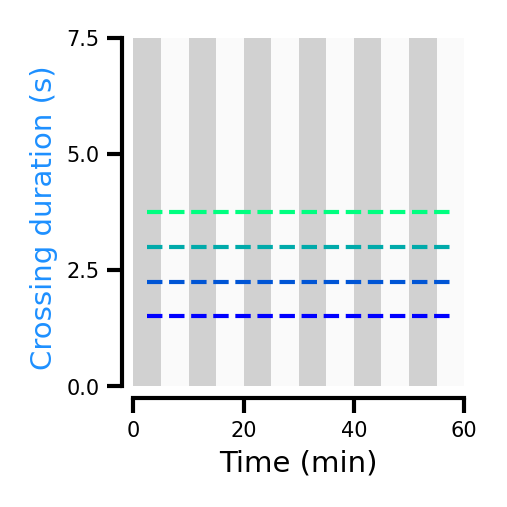

In [7]:
# plot variable median/mean fir each block
def Figure2A(ax=None):
    if ax is None:
        ax = plt.gca()

    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

    dummy_data = [2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25, 2.25]
    modifs = [-0.75, 0, 0.75, 1.5]
    
    cmap = plt.get_cmap('winter', len(modifs))
    for idx, modif in enumerate(modifs):
        ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                [dummy_data[i] + modif for i in range(0, len(blocks))],
                color=cmap(idx), ls='--')

    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)
    
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Crossing duration (s)", color='dodgerblue')
    ax.set_xlim(0, 60)
    ax.set_ylim(0, 7.5)
    ax.set_yticks([0, 2.5, 5, 7.5])
    space_axes(ax)


fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure2A(ax=ax)


# l, b, h, w = 0.9, .65, 0.2, 0.06
# ax1 = fig.add_axes([l, b, w, h])

# plot_colorbar(ax=ax1, fig=fig, label=r'$\mu_0$', cmap='winter', labels=[1.5, 0, 3.75])

# 2B $\mu_t$

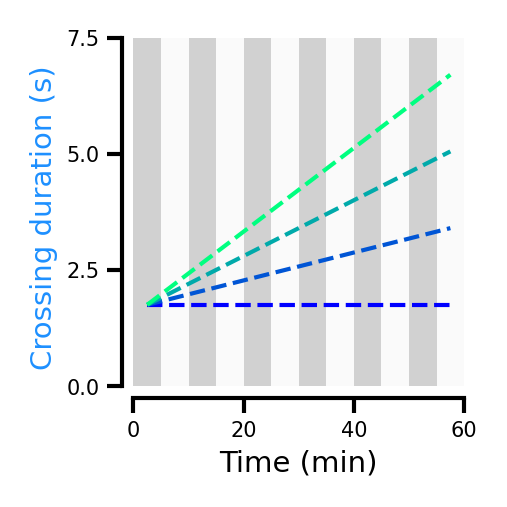

In [8]:
# plot variable median/mean fir each block
def Figure2B(ax=None):

    if ax is None:
        ax = plt.gca()

    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

    dummy_data = [1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75]
    modifs = [0, 0.15, .3, .45]
    cmap = plt.get_cmap('winter', len(modifs))
    
    for idx, modif in enumerate(modifs):
        ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                [dummy_data[i] + (i*modif) for i in range(0, len(blocks))],
                color=cmap(idx), ls='--')

    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)
    
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Crossing duration (s)", color='dodgerblue')
    ax.set_xlim(0, 60)
    ax.set_ylim(0, 7.5)
    ax.set_yticks([0, 2.5, 5, 7.5])
    space_axes(ax)


fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure2B(ax=ax)

# 2C $\mu_R$

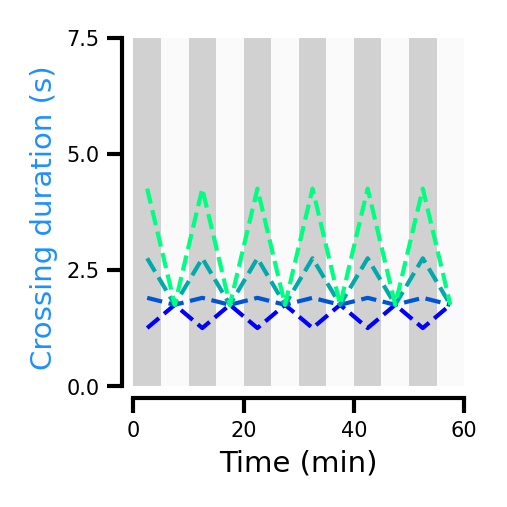

In [9]:
# plot variable median/mean fir each block
def Figure2C(ax=None):

    if ax is None:
        ax = plt.gca()

    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

    # dummy_data = [1.75, 2.7, 1.75, 2.75, 1.75, 2.75, 1.75, 2.7, 1.75, 2.75, 1.75, 2.80]

    dummy_data = [1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75, 1.75]
    modifs = [-.5, .15, 1, 2.5]
    cmap = plt.get_cmap('winter', len(modifs))

    for idx, modif in enumerate(modifs):
        
        ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
                [dummy_data[i] + modif if i % 2 == 0 else dummy_data[i] for i in range(0, len(blocks)) ],
                color=cmap(idx), ls='--')

    
    dummy_data = [1.25, 1.7, 1.2, 1.75, 1.2, 1.75, 1.25, 1.7, 1.30, 1.75, 1.25, 1.80]
 
    
    dummy_data = [1.25, 4.2, 1.2, 4.25, 1.2, 4.25, 1.25, 4.2, 1.30, 4.25, 1.25, 4.30] 


    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)

    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Crossing duration (s)", color='dodgerblue')
    ax.set_xlim(0, 60)
    ax.set_ylim(0, 7.5)
    ax.set_yticks([0, 2.5, 5, 7.5])
    space_axes(ax)

fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure2C(ax=ax)

# 2D model + data

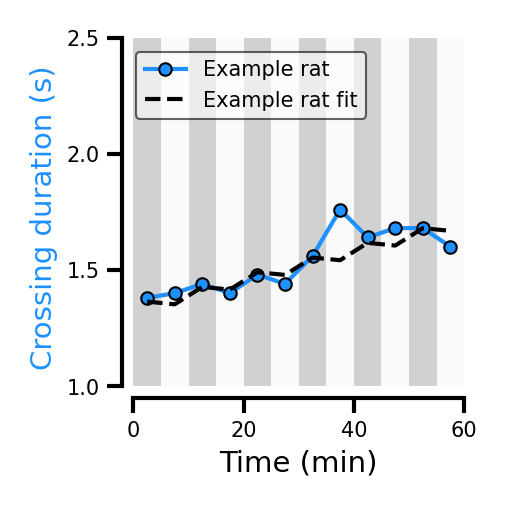

In [10]:
# plot variable median/mean fir each block, example session example rat
def Figure2D(ax=None):
    if ax is None:
        ax = plt.gca()

    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]

    dummy_data = [1.25, 2.25, 1.5, 2.75, 2, 3.5, 2.4, 4.2, 3.2, 5.2, 3.5, 6.3]
    # ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
    #         [dummy_data[i] for i in range(0, len(blocks))],  # or use median
    #         # marker='o', ms=3, 
    #         color='dodgerblue', 
    #         zorder=4, markeredgecolor='k', markeredgewidth=0.5,
    #         ls='--', label='Synthetic data')
    
    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)
    
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Crossing duration (s)", color='dodgerblue')
    ax.set_xlim(0, 60)
    ax.set_ylim(1, 2.5)
    ax.set_yticks([1, 1.5, 2, 2.5])
    space_axes(ax)


    # experimental rat data

    root = "/home/david/Desktop/ALLDATA"
    animal='RatM00'
    session='RatM00_2021_07_22_16_13_03'

    _params = get_from_pickle(root, animal, session, name="params.p")
    blocks = _params['blocks']
    rewardProbaBlock = _params['rewardProbaBlock']
    example_runningTimeInLeftBin, example_runningTimeInRightBin = get_from_pickle(root, animal, session, name="timeRun.p")
    data = [example_runningTimeInLeftBin[i]+example_runningTimeInRightBin[i] for i in range(0, 12)]

    ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
            [np.median(data[i]) for i in range(0, len(blocks))],  # or use median
            marker='o', ms=3, color='dodgerblue', 
            zorder=4, markeredgecolor='k', markeredgewidth=0.5, label='Example rat')


    # fit, generate samples from distribution with fit parameters, take median
    N_bins = 6
    N_avg = 4
    ex_mu, ex_mu_t, ex_mu_R, ex_sigma, ex_sigma_t, ex_sigma_R = pickle.load(open("picklejar/crossing_time_fit_example_session.p", "rb"))
    #print(ex_mu, ex_mu_t, ex_mu_R, ex_sigma, ex_sigma_t, ex_sigma_R)
    MU = np.zeros((N_bins, N_avg))
    SIGMA = np.zeros((N_bins, N_avg))

    for bin in range(N_bins):
        for avg in range(N_avg):
            MU[bin, avg] = ex_mu + bin*ex_mu_t + avg*ex_mu_R
            SIGMA[bin, avg] = ex_sigma + bin*ex_sigma_t + avg*ex_sigma_R

    m = []
    s = []
    for i in range(6):
        m.append((.9*MU[i][0] + 0.1*MU[i][1]))
        m.append((.9*MU[i][-1] + 0.1*MU[i][-2]))
        s.append((.9*SIGMA[i][0] + 0.1*SIGMA[i][1]))
        s.append((.9*SIGMA[i][-1] + 0.1*SIGMA[i][-2]))

    res = [np.median(generate_running_time(m[i], 0*s[i], 1000)) for i in range(12)]
    
    ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))],
            [res[i] for i in range(0, len(blocks))],
            color='k', ls='--', label='Example rat fit', zorder=5)

    # error = np.mean(np.sqrt([(np.median(data[i]) - res[i])**2 for i in range(0, len(blocks))]))
    # print((error))

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='upper left', bbox_to_anchor=(0.01, 0.99), frameon=True, fontsize=5, markerscale=1, edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)


fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure2D(ax=ax)

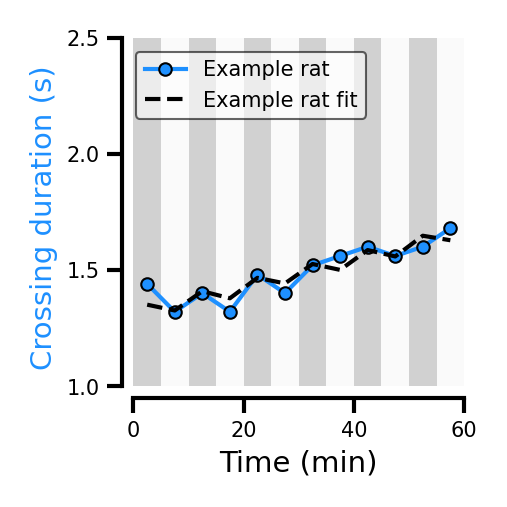

In [11]:
# plot variable median/mean fir each block, all 120 cm sessions example rat
def _Figure2D(ax=None):
    if ax is None:
        ax = plt.gca()

    rewardProbaBlock = [90, 10, 90, 10, 90, 10, 90, 10, 90, 10, 90, 10]
    blocks =  [[0, 300],  [300, 600],  [600, 900],  [900, 1200],
                [1200, 1500],  [1500, 1800],  [1800, 2100],  [2100, 2400],
                [2400, 2700],  [2700, 3000],  [3000, 3300],  [3300, 3600]]
    
    for i in range(0, len(blocks)):
        ax.axvspan(blocks[i][0]/60, blocks[i][1]/60, ymin=1/30, ymax=1, color='grey', alpha=rewardProbaBlock[i]/250, lw=0)
    
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Crossing duration (s)", color='dodgerblue')
    ax.set_xlim(0, 60)
    ax.set_ylim(1, 2.5)
    ax.set_yticks([1, 1.5, 2, 2.5])
    space_axes(ax)


    # experimental rat data

    root = "/home/david/Desktop/ALLDATA"
    animal='RatM00'
    session='RatM00_2021_07_22_16_13_03'

    _params = get_from_pickle(root, animal, session, name="params.p")
    blocks = _params['blocks']
    rewardProbaBlock = _params['rewardProbaBlock']


    sessions = matchsession(animal, dist120)
    data = [[],[],[],[],[],[],[],[],[],[],[],[]]
    for i, session in enumerate(sessions):
        example_runningTimeInLeftBin, example_runningTimeInRightBin = get_from_pickle(root, animal, session, name="timeRun.p")
        for j in range(0, 12):
            data[j] = np.append(data[j], example_runningTimeInLeftBin[j]+example_runningTimeInRightBin[j])


    ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))], 
            [np.median(data[i]) for i in range(0, len(blocks))],  # or use median
            marker='o', ms=3, color='dodgerblue', 
            zorder=4, markeredgecolor='k', markeredgewidth=0.5, label='Example rat')
    

    # fit, generate samples from distribution with fit parameters, take median
    N_bins = 6
    N_avg = 4
    #ex_mu, ex_mu_t, ex_mu_R, ex_sigma, ex_sigma_t, ex_sigma_R = pickle.load(open("picklejar/crossing_time_fit_example_session.p", "rb"))
    #print(ex_mu, ex_mu_t, ex_mu_R, ex_sigma, ex_sigma_t, ex_sigma_R)
    
    _, _, _, _, _, _, ex_mu, ex_mu_t, ex_mu_R, ex_sigma, ex_sigma_t, ex_sigma_R = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))
    ex_mu = ex_mu[animal]['120']
    ex_mu_t = ex_mu_t[animal]['120']
    ex_mu_R = ex_mu_R[animal]['120']
    ex_sigma = ex_sigma[animal]['120']
    ex_sigma_t = ex_sigma_t[animal]['120']
    ex_sigma_R = ex_sigma_R[animal]['120']

    MU = np.zeros((N_bins, N_avg))
    SIGMA = np.zeros((N_bins, N_avg))

    for bin in range(N_bins):
        for avg in range(N_avg):
            MU[bin, avg] = ex_mu + bin*ex_mu_t + avg*ex_mu_R
            SIGMA[bin, avg] = ex_sigma + bin*ex_sigma_t + avg*ex_sigma_R

    m = []
    s = []
    for i in range(6):
        m.append((.9*MU[i][0] + 0.1*MU[i][1]))
        m.append((.9*MU[i][-1] + 0.1*MU[i][-2]))
        s.append((.9*SIGMA[i][0] + 0.1*SIGMA[i][1]))
        s.append((.9*SIGMA[i][-1] + 0.1*SIGMA[i][-2]))

    res = [np.median(generate_running_time(m[i], s[i], len(data[i]))) for i in range(12)]

    ax.plot([(blocks[i][1] + blocks[i][0])/120 for i in range(0, len(blocks))],
            [res[i] for i in range(0, len(blocks))],
            color='k', ls='--', label='Example rat fit', zorder=5)


    # error = [np.sqrt((np.median(data[i]) - res[i])**2) for i in range(0, len(blocks))]
    # total_trials = np.sum([len(data[i]) for i in range(0, len(blocks))])
    # weighted_error = [error[i]*len(data[i])/total_trials for i in range(0, len(blocks))]
    # error = np.mean(weighted_error)
    # overall_median = np.median([np.median(data[i]) for i in range(0, len(blocks))])
    # print(f'median crossing time: {overall_median:.2f} s')
    # print(f'error: {error:.4f} s')
    # print(f'error %: {(error/overall_median)*100:.2f} %')


    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='upper left', bbox_to_anchor=(0.01, 0.99), frameon=True, fontsize=5, markerscale=1, edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)


fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
_Figure2D(ax=ax)

# 2E schematic distance

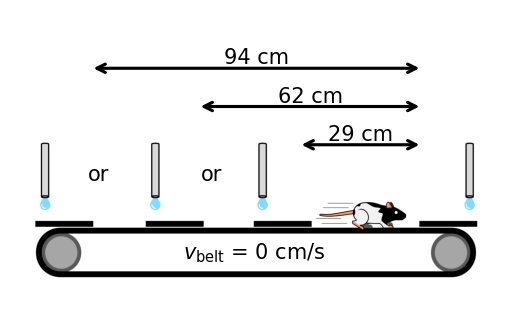

In [12]:
def Figure2E(ax=None, path=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    if path is None:
        path = "/home/david/Desktop/code/Figures/2Drun.png"

    img = plt.imread(path)
    img = img[300:2000, 150:3075]
    ax.imshow(img)
    ax.axis("off")
    ax.text(s=r'$v_{\mathrm{belt}}$ = 0 cm/s', x=img.shape[1]/2, y=1460, ha="center", va="center", fontsize=5)
    ax.text(s='or', x=450, y=950, ha="center", va="center", fontsize=5)
    ax.text(s='or', x=1185, y=950, ha="center", va="center", fontsize=5)

    ax.annotate(text='', xy=(1720, 750), xytext=(2600, 750), arrowprops=dict(arrowstyle='<->', lw=0.75), fontsize=5, zorder=5)
    ax.annotate(text='', xy=(1060, 500), xytext=(2600, 500), arrowprops=dict(arrowstyle='<->', lw=0.75), fontsize=5, zorder=5)
    ax.annotate(text='', xy=(360, 250), xytext=(2600, 250), arrowprops=dict(arrowstyle='<->', lw=0.75), fontsize=5, zorder=5)
    
    ax.annotate(text='29 cm', xy=(0, 0), xytext=((1720+2600)/2, 750), ha='center', va='bottom', xycoords='data', fontsize=5, zorder=5)
    ax.annotate(text='62 cm', xy=(0, 0), xytext=((1060+2600)/2, 500), ha='center', va='bottom', xycoords='data', fontsize=5, zorder=5)
    ax.annotate(text='94 cm', xy=(0, 0), xytext=((360+2600)/2, 250), ha='center', va='bottom', xycoords='data', fontsize=5, zorder=5)

fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure2E(ax=ax)

# 2FGH fit result dist

In [13]:
def plotmedian(var, ax=None, dist_or_tm='dist', do=False):
    if do:
        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
        if dist_or_tm == 'dist':
            ax.plot([0, 1, 2], [np.median([var[animal]["60"] for animal in animalList]), 
                                np.median([var[animal]["90"] for animal in animalList]),
                                np.median([var[animal]["120"] for animal in animalList])],
                                color='k', label=f'Median (n={len(animalList)})')
        elif dist_or_tm == 'tm':
            ax.plot([0, 1, 2, 3, 4], [np.median([var[animal]["20"] for animal in animalList]), 
                                np.median([var[animal]["10"] for animal in animalList]),
                                np.median([var[animal]["2"] for animal in animalList]),
                                np.median([var[animal]["rev10"] for animal in animalList]),
                                np.median([var[animal]["rev20"] for animal in animalList])],
                                color='k')
        

p_value_60_90: 0.0 p_value_60_120: 0.0001 p_value_90_120: 0.0004
p_value_60_90: 0.0663 p_value_60_120: 0.0609 p_value_90_120: 0.3884
p_value_60_90: 0.1656 p_value_60_120: 0.8437 p_value_90_120: 0.4833


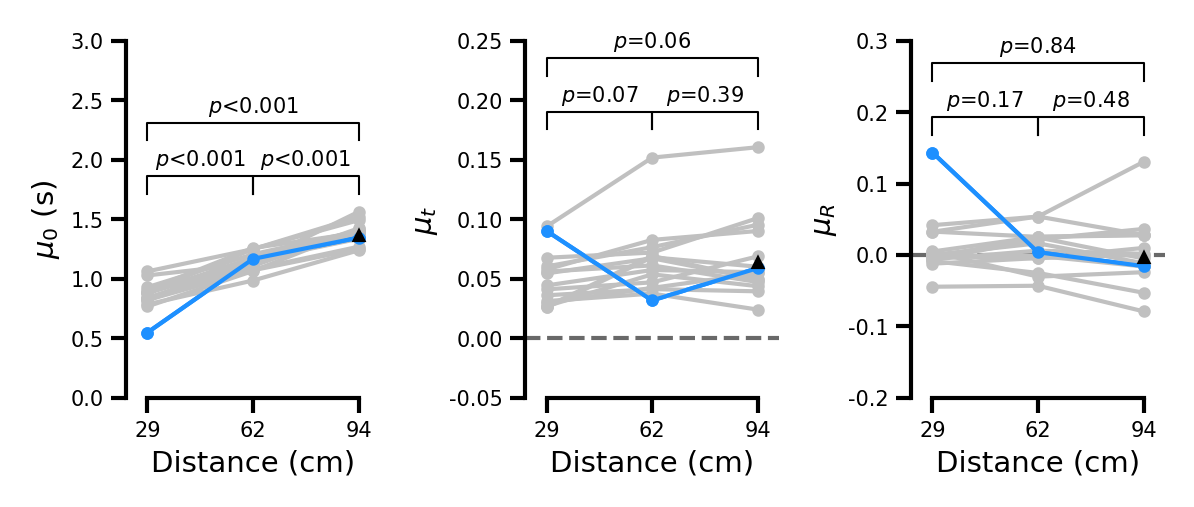

In [14]:
def Figure2F(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    # ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5, zorder=0)

    _, _, _, _, _, _, mu_0, _, _, _, _, _ = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2], [mu_0[animal]["60"], mu_0[animal]["90"], mu_0[animal]["120"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        
        if animal == 'RatM00':
            ax.plot([0, 1, 2], [mu_0[animal]["60"], mu_0[animal]["90"], mu_0[animal]["120"]], 
                        color=rat_markers[animal][0], marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=5)

    
    ex_mu, ex_mu_t, ex_mu_R, ex_sigma, ex_sigma_t, ex_sigma_R = pickle.load(open("picklejar/crossing_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_mu, color='black', marker='^', zorder=10, markersize=2, linewidth=0)
    
    
    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    ax.set_xlabel("Distance (cm)")

    ax.set_ylim(0, 3)
    ax.set_ylabel(r'$\mu_0$' + ' (s)')
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)

    # avg60 = np.median([mu_0[animal]["60"] for animal in animalList])
    # ax.plot([0, 1, 2], [avg60, (62/29)*avg60, (94/29)*avg60], color='gray', linestyle='--', linewidth=1, zorder=0,)
    # ax.text(s='Constant speed', x=.8, y=2, ha="left", va="center", fontsize=5, color='gray', rotation=50)

    plotmedian(mu_0, ax=ax, dist_or_tm='dist')
    permutation_test_distances(mu_0, ax=ax, h='top', num_permutations=10000)
    
        
def Figure2G(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    _, _, _, _, _, _, _, mu_t, _, _, _, _ = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2], [mu_t[animal]["60"], mu_t[animal]["90"], mu_t[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])

        if animal == 'RatM00':
            ax.plot([0, 1, 2], [mu_t[animal]["60"], mu_t[animal]["90"], mu_t[animal]["120"]], 
                            color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                            markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)
    
    ex_mu, ex_mu_t, ex_mu_R, ex_sigma, ex_sigma_t, ex_sigma_R = pickle.load(open("picklejar/crossing_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_mu_t, color='black', marker='^', zorder=10, markersize=2, linewidth=0)
    
    
    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    ax.set_xlabel("Distance (cm)")

    ax.set_ylim(-0.05, .25)
    # ax.set_yticks([-.05, 0, 0.05, .15, .25,])
    ax.set_ylabel(r'$\mu_t$')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, zorder=0)
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)
    plotmedian(mu_t, ax=ax, dist_or_tm='dist')
    permutation_test_distances(mu_t, ax=ax, h='top', num_permutations=10000)


def Figure2H(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    _, _, _, _, _, _, _, _, mu_R, _, _, _ = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2], [mu_R[animal]["60"], mu_R[animal]["90"], mu_R[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        
        if animal == 'RatM00':
            ax.plot([0, 1, 2], [mu_R[animal]["60"], mu_R[animal]["90"], mu_R[animal]["120"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)


    ex_mu, ex_mu_t, ex_mu_R, ex_sigma, ex_sigma_t, ex_sigma_R = pickle.load(open("picklejar/crossing_time_fit_example_session.p", "rb"))
    ax.plot(2, ex_mu_R, color='black', marker='^', zorder=10, markersize=2, linewidth=0)
    


    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    ax.set_xlabel("Distance (cm)")

    ax.set_ylim(-.2, .3)
    ax.set_yticks([-.2, -.1, 0, .1, .2, .3])
    ax.set_ylabel(r'$\mu_R$')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, zorder=0)
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)
    plotmedian(mu_R, ax=ax, dist_or_tm='dist')
    permutation_test_distances(mu_R, ax=ax, h='top', num_permutations=10000)

fig, axs = plt.subplots(1, 3, figsize=(cm2inch(18)*6/11, cm2inch(4)), dpi=300)
Figure2F(axs[0])
Figure2G(axs[1])
Figure2H(axs[2])

# 2I mean run speed Distance

p_value_60_90: 0.0001 p_value_60_120: 0.0002 p_value_90_120: 0.0003


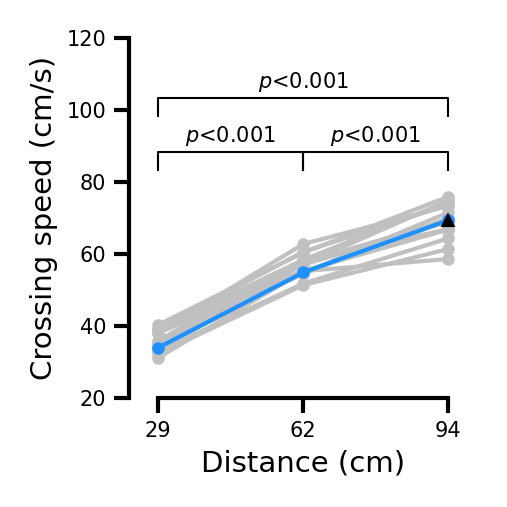

In [15]:
def Figure2I(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    conds = ["60", "90", "120"]
    run_speeds = {k: {a: [] for a in conds} for k in animalList}
    run_speeds2 = {k: {a: [] for a in conds} for k in animalList}

    for cond, sessionlist in zip(conds, [dist60, dist90, dist120]):
        for animal in animalList:
            for session in matchsession(animal, sessionlist):
                params = get_from_pickle(root, animal, session, name="params.p")
                for elem in sequence[animal, session]:
                    if get_block(sequence[animal, session][elem][0]) <= 1:
                        if sequence[animal, session][elem][1] == 'run':
                            tm_speed = params['treadmillSpeed'][get_block(sequence[animal, session][elem][0])]
                            run_speeds[animal][cond].append(abs(sequence[animal, session][elem][-1]) - tm_speed)

    for animal in animalList:
        for cond in conds:
            run_speeds2[animal][cond] = np.median(run_speeds[animal][cond])

    
    # effect_of_condition(run_speeds2, conds=['60', '90', '120'], name='runspeed')

    for animal in animalList:
        ax.plot([0, 1, 2], [np.median(run_speeds[animal][cond]) for cond in conds], color=rat_markers[animal][0],
                marker=rat_markers[animal][1], markersize=2, label=f'Individuals (n={len(animalList)})')

        if animal == "RatM00":
            pickle.dump([np.median(run_speeds[animal][cond]) for cond in conds], open("picklejar/example_rat_run_speeds_dist.p", "wb"))
            ax.plot([0, 1, 2], [np.median(run_speeds[animal][cond]) for cond in conds], color=rat_markers[animal][0],
                    marker=rat_markers[animal][1], markersize=2, zorder=10, label='Example rat')

    animal='RatM00'
    session='RatM00_2021_07_22_16_13_03'
    example_session_run_speeds = []
    params = get_from_pickle(root, animal, session, name="params.p")
    for elem in sequence[animal, session]:
        if get_block(sequence[animal, session][elem][0]) <= 1:
            if sequence[animal, session][elem][1] == 'run':
                tm_speed = params['treadmillSpeed'][get_block(sequence[animal, session][elem][0])]
                example_session_run_speeds.append(abs(sequence[animal, session][elem][-1]) - tm_speed)

    ax.plot(2, np.median(example_session_run_speeds), color='black', marker='^', zorder=10, markersize=2, linewidth=0, label='Example session')
    ax.set_xlim(0, 2)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    ax.set_xlabel("Distance (cm)")


    ax.set_ylim(20, 120)
    ax.set_yticks([20, 40, 60, 80, 100, 120])
    ax.set_ylabel("Crossing speed (cm/s)")
    plotmedian(run_speeds2, ax=ax, dist_or_tm='dist')

    permutation_test_distances(run_speeds2, ax=ax, h='top', shifty=.025, num_permutations=10000)
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)
    

fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure2I(ax=ax)

# 2J schematic vbelt

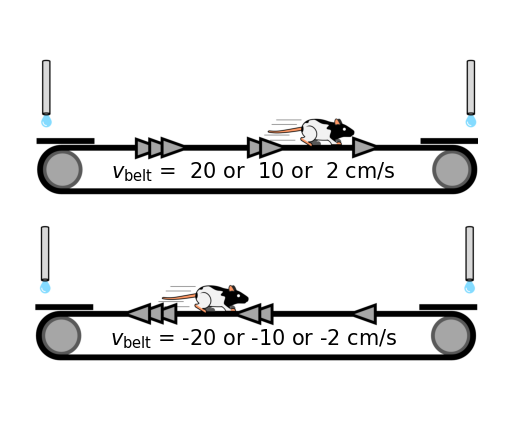

In [16]:
def Figure2J(ax=None, path=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    if path is None:
        path = "/home/david/Desktop/code/Figures/2Erun.png"

    img = plt.imread(path)
    img = img[:, 150:3075]
    ax.imshow(img)
    ax.axis("off")
    ax.text(s=r'$v_{\mathrm{belt}}$ =  20 or  10 or  2 cm/s', x=img.shape[1]/2, y=930, ha="center", va="center", fontsize=5)
    ax.text(s=r'$v_{\mathrm{belt}}$ = -20 or -10 or -2 cm/s', x=img.shape[1]/2, y=2020, ha="center", va="center", fontsize=5)

fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure2J(ax=ax)

# 2KLM fit results vbelt

p_value_20_0: 0.1204 p_value_0_rev20: 0.0004 p_value_20_rev20: 0.0009
p_value_20_0: 0.0148 p_value_0_rev20: 0.8403 p_value_20_rev20: 0.0125
p_value_20_0: 0.5012 p_value_0_rev20: 0.4065 p_value_20_rev20: 0.0311


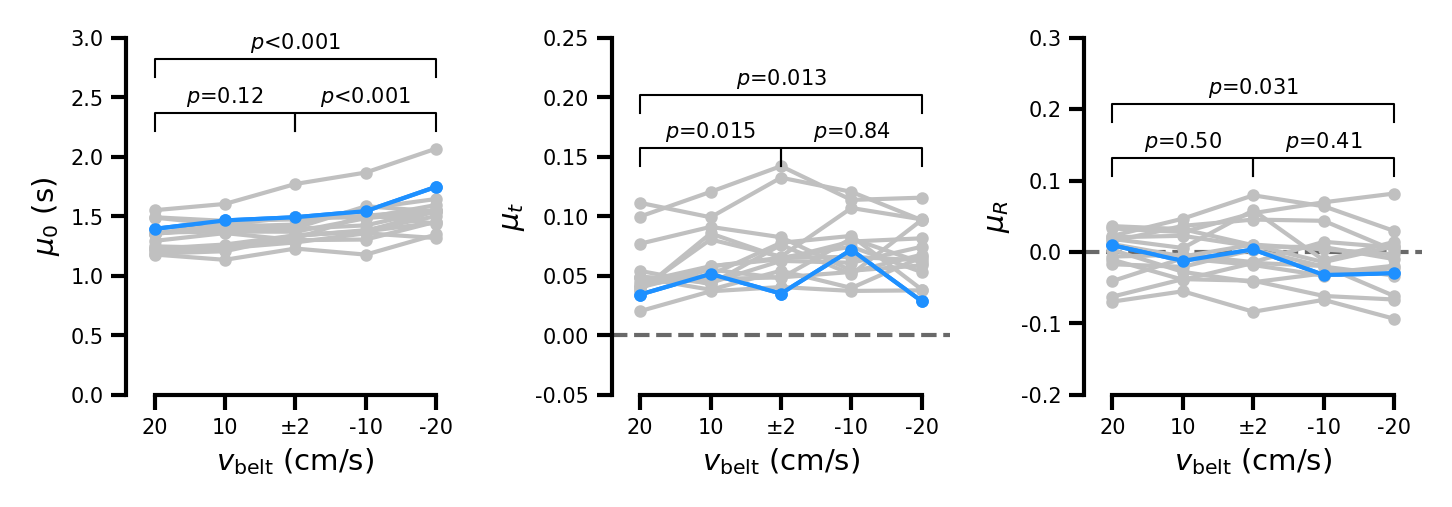

In [17]:
def Figure2K(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    _, _, _, _, _, _, mu_0, _, _, _, _, _ = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2, 3, 4], [mu_0[animal]["20"], mu_0[animal]["10"], mu_0[animal]["2"], mu_0[animal]["rev10"], mu_0[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
    
        if animal == "RatM00":
            ax.plot([0, 1, 2, 3, 4], [mu_0[animal]["20"], mu_0[animal]["10"], mu_0[animal]["2"], mu_0[animal]["rev10"], mu_0[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)
    
    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["20", "10", "±2", "-10", "-20"])
    _ = r'$v_{\mathrm{belt}}$'
    ax.set_xlabel(f'{_} (cm/s)')

    ax.set_ylim(0, 3)
    ax.set_ylabel(r'$\mu_0$' + ' (s)')
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)
    plotmedian(mu_0, ax=ax, dist_or_tm='tm')
    permutation_test_vbelt(mu_0, ax=ax, num_permutations=10000)

def Figure2L(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    _, _, _, _, _, _, _, mu_t, _, _, _, _ = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2, 3, 4], [mu_t[animal]["20"], mu_t[animal]["10"], mu_t[animal]["2"], mu_t[animal]["rev10"], mu_t[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        if animal == "RatM00":
            ax.plot([0, 1, 2, 3, 4], [mu_t[animal]["20"], mu_t[animal]["10"], mu_t[animal]["2"], mu_t[animal]["rev10"], mu_t[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)

    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["20", "10", "±2", "-10", "-20"])
    _ = r'$v_{\mathrm{belt}}$'
    ax.set_xlabel(f'{_} (cm/s)')

    ax.set_ylim(-.05, .25)
    ax.set_yticks([-.05, 0, 0.05, .1, .15, .2, .25])
    ax.set_ylabel(r'$\mu_t$')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, zorder=0)
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)
    plotmedian(mu_t, ax=ax, dist_or_tm='tm')
    permutation_test_vbelt(mu_t, ax=ax, shifty=-.05, num_permutations=10000)

def Figure2M(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    _, _, _, _, _, _, _, _, mu_R, _, _, _ = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))

    for animal in animalList:
        ax.plot([0, 1, 2, 3, 4], [mu_R[animal]["20"], mu_R[animal]["10"], mu_R[animal]["2"], mu_R[animal]["rev10"], mu_R[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]])
        if animal == "RatM00":
            ax.plot([0, 1, 2, 3, 4], [mu_R[animal]["20"], mu_R[animal]["10"], mu_R[animal]["2"], mu_R[animal]["rev10"], mu_R[animal]["rev20"]], 
                        color=rat_markers[animal][0], label=animal, marker=rat_markers[animal][1], 
                        markersize=2, linestyle=lines[brainstatus[animal]], zorder=10)
    
    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["20", "10", "±2", "-10", "-20"])
    _ = r'$v_{\mathrm{belt}}$'
    ax.set_xlabel(f'{_} (cm/s)')

    ax.set_ylim(-.2, .3)
    ax.set_yticks([-.2, -.1, 0, .1, .2, .3])
    ax.set_ylabel(r'$\mu_R$')
    ax.axhline(0, color='dimgray', linestyle='--', linewidth=1, zorder=0)
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)
    plotmedian(mu_R, ax=ax, dist_or_tm='tm')
    permutation_test_vbelt(mu_R, ax=ax, num_permutations=10000)

fig, axs = plt.subplots(1, 3, figsize=(cm2inch(12), cm2inch(4)))
Figure2K(axs[0])
Figure2L(axs[1])
Figure2M(axs[2])

# 2N mean run speed vbelt

p_value_20_0: 0.0002 p_value_0_rev20: 0.0002 p_value_20_rev20: 0.0001


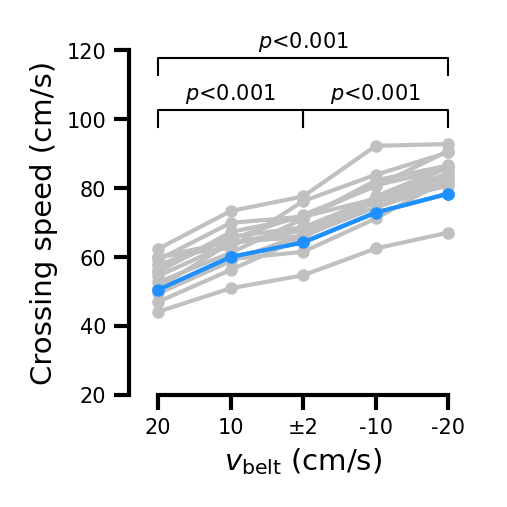

In [18]:
def Figure2N(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    conds = ["20", "10", "2", "rev10", "rev20"]
    run_speeds = {k: {a: [] for a in conds} for k in animalList}
    run_speeds2 = {k: {a: [] for a in conds} for k in animalList}

    for cond, sessionlist in zip(conds, [TM20, TM10, TM2, TMrev10, TMrev20]):
        for animal in animalList:
            for session in matchsession(animal, sessionlist):
                params = get_from_pickle(root, animal, session, name="params.p")
                for elem in sequence[animal, session]:
                    if get_block(sequence[animal, session][elem][0]) <= 1:
                        if sequence[animal, session][elem][1] == 'run':
                            tm_speed = params['treadmillSpeed'][get_block(sequence[animal, session][elem][0])]
                            run_speeds[animal][cond].append(abs(sequence[animal, session][elem][-1]) - tm_speed)

    for animal in animalList:
        for cond in conds:
            run_speeds2[animal][cond] = np.median(run_speeds[animal][cond])

    # effect_of_condition(run_speeds2, conds=conds, name='runspeed')
    # plotmedian(run_speeds2, ax=ax, dist_or_tm='tm')

    for animal in animalList:
        ax.plot([0, 1, 2, 3, 4], [np.median(run_speeds[animal][cond]) for cond in conds], color=rat_markers[animal][0],
                marker=rat_markers[animal][1], markersize=2)
        
        if animal == 'RatM00':
            pickle.dump([np.median(run_speeds[animal][cond]) for cond in conds], open("picklejar/example_rat_run_speeds_tm.p", "wb"))
            ax.plot([0, 1, 2, 3, 4], [np.median(run_speeds[animal][cond]) for cond in conds], color=rat_markers[animal][0],
                marker=rat_markers[animal][1], markersize=2, zorder=10)
                
    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(["20", "10", "±2", "-10", "-20"])
    _ = r'$v_{\mathrm{belt}}$'
    ax.set_xlabel(f'{_} (cm/s)')

    ax.set_ylim(20, 120)
    ax.set_yticks([20, 40, 60, 80, 100, 120])
    ax.set_ylabel("Crossing speed (cm/s)")

    permutation_test_vbelt(run_speeds2, h='top', ax=ax, num_permutations=10000)
    space_axes(ax, y_ratio=0, x_ratio_left=.1, x_ratio_right=.1)

fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure2N(ax=ax)

# Figure 2

p_value_60_90: 0.0004 p_value_60_120: 0.0002 p_value_90_120: 0.0004
p_value_60_90: 0.0626 p_value_60_120: 0.0618 p_value_90_120: 0.3872
p_value_60_90: 0.1666 p_value_60_120: 0.8474 p_value_90_120: 0.4907
p_value_60_90: 0.0001 p_value_60_120: 0.0 p_value_90_120: 0.0004
p_value_20_0: 0.1239 p_value_0_rev20: 0.0003 p_value_20_rev20: 0.0022
p_value_20_0: 0.013 p_value_0_rev20: 0.8454 p_value_20_rev20: 0.0125
p_value_20_0: 0.5001 p_value_0_rev20: 0.4058 p_value_20_rev20: 0.0299
p_value_20_0: 0.0002 p_value_0_rev20: 0.0008 p_value_20_rev20: 0.0001


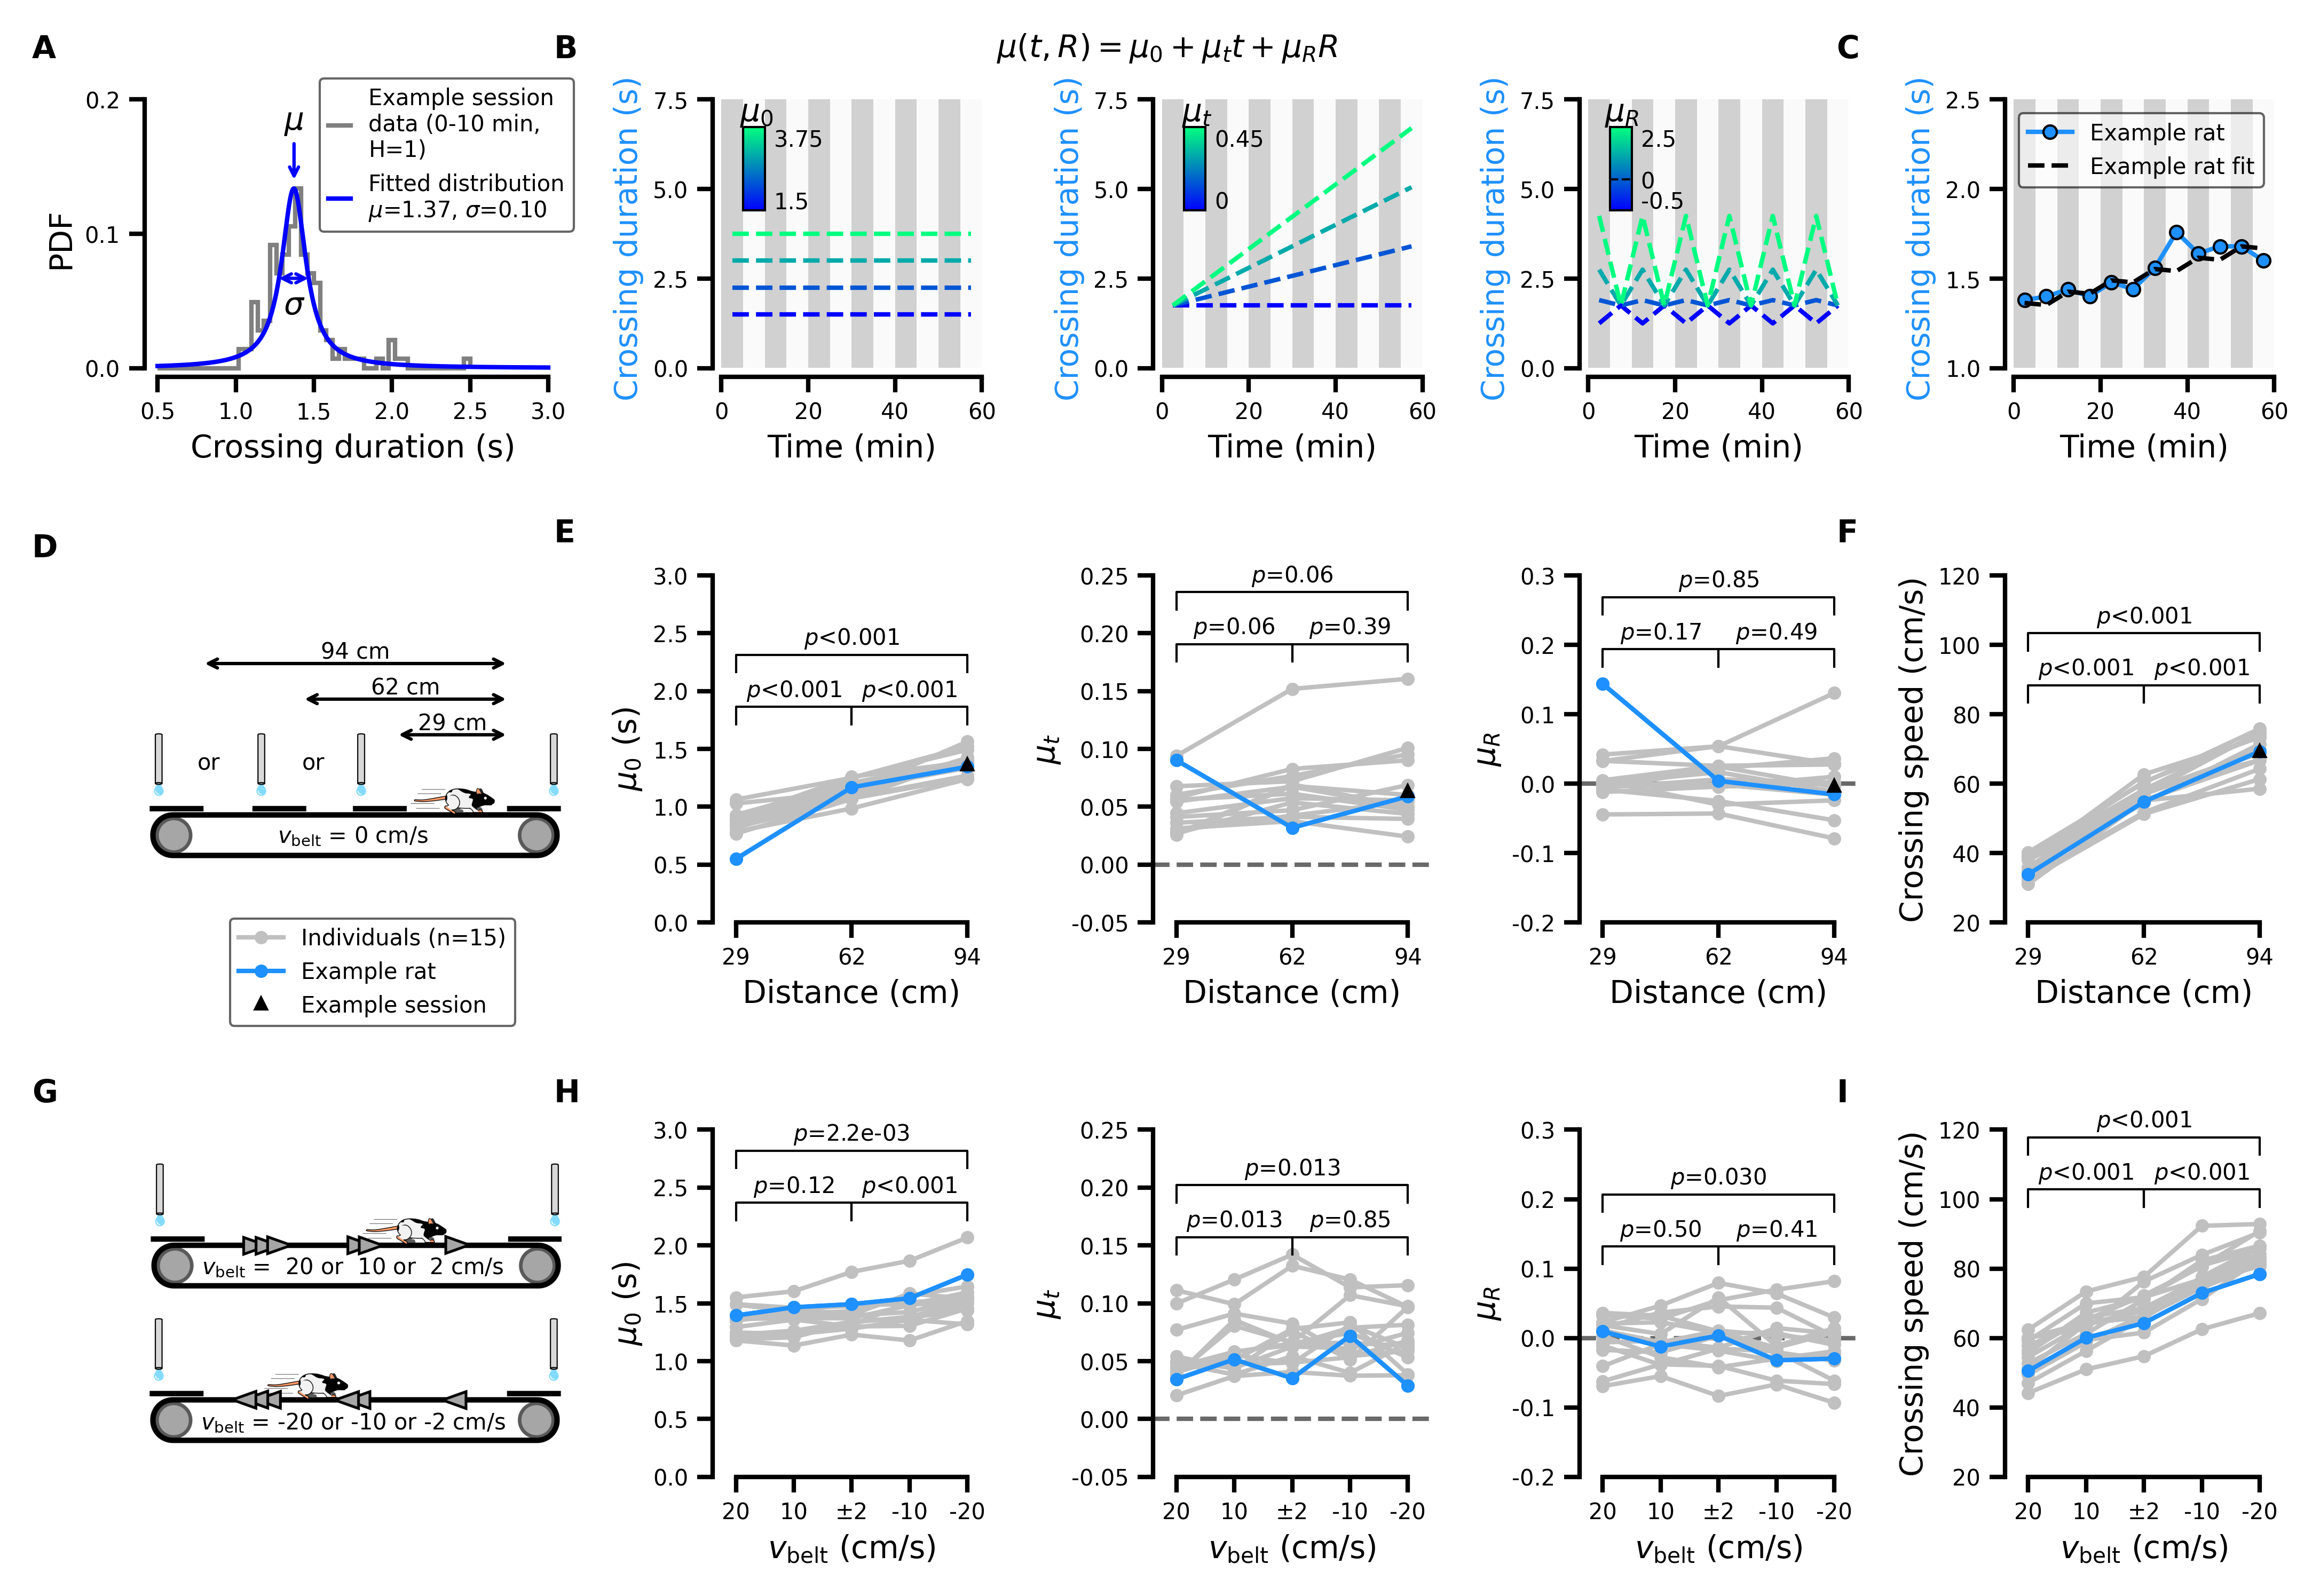

In [20]:

fig = plt.figure(figsize=(cm2inch(18), cm2inch(12)), constrained_layout=True, facecolor='w', dpi=600)

gs0 = fig.add_gridspec(5, 5, wspace=.5, hspace=.5, 
                       height_ratios=[8, 1, 10, 1, 10], width_ratios=[3, 2, 2, 2, 2])


explanation_mu = plt.subplot(gs0[0, 0])
explanation_mu_0 = plt.subplot(gs0[0, 1])
explanation_mu_t = plt.subplot(gs0[0, 2])
explanation_mu_R = plt.subplot(gs0[0, 3])
modeldata = plt.subplot(gs0[0, 4])

schematic_distances = plt.subplot(gs0[2, 0])
fit_mu_0_distance = plt.subplot(gs0[2, 1])
fit_mu_t_distance = plt.subplot(gs0[2, 2])
fit_mu_R_distance = plt.subplot(gs0[2, 3])
speed_distance = plt.subplot(gs0[2, 4])

schematic_vbelts = plt.subplot(gs0[4, 0])
fit_mu_0_vbelt = plt.subplot(gs0[4, 1])
fit_mu_t_vbelt = plt.subplot(gs0[4, 2])
fit_mu_R_vbelt = plt.subplot(gs0[4, 3])
speed_vbelt = plt.subplot(gs0[4, 4])



plot_mu(explanation_mu)
Figure2A(ax=explanation_mu_0)
Figure2B(ax=explanation_mu_t)
Figure2C(ax=explanation_mu_R)
Figure2D(ax=modeldata)

Figure2E(ax=schematic_distances)
Figure2F(ax=fit_mu_0_distance)
Figure2G(ax=fit_mu_t_distance)
Figure2H(ax=fit_mu_R_distance)
Figure2I(ax=speed_distance)

Figure2J(ax=schematic_vbelts)
Figure2K(ax=fit_mu_0_vbelt)
Figure2L(ax=fit_mu_t_vbelt)
Figure2M(ax=fit_mu_R_vbelt)
Figure2N(ax=speed_vbelt)

# letter labels
figuresLabels={"A":[0.00, 1.00], "B":[0.23, 1.00], "C":[0.795, 1.00],
               "D":[0.00, 0.67], "E":[0.23, 0.68], "F":[0.795, 0.68], 
                "G":[0.00, 0.31], "H":[0.23, 0.31], "I":[0.795, 0.31],}

for label,coordinates in sorted(figuresLabels.items()):
    fig.text(coordinates[0], coordinates[1], label, figure=fig, 
             weight='bold', fontsize=7, ha='left', va='bottom')

# legend EFHI
handles, labels = speed_distance.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
fig.legend(*zip(*unique), loc='center', bbox_to_anchor=(0.15, .4), 
                            frameon=True, fontsize=5, markerscale=1, 
                            edgecolor='k', facecolor='w', 
                            # title='Legend for all figures:     ', title_fontsize=5
                            ).get_frame().set_linewidth(.5)


# colorbars
fig.canvas.draw()
bounds = [_ax.get_position().bounds for _ax in fig.axes]
fig.set_constrained_layout(False)

plot_colorbar(ax_input=explanation_mu_0, x=.11, y=.6, width=.078, height=.3, 
              label=r'$\mu_0$', y_label=1.35, labelpad=-15, 
              cmap='winter', labels=[1.5, 0, 3.75])

plot_colorbar(ax_input=explanation_mu_t, x=.11, y=.6, width=.078, height=.3, 
              label=r'$\mu_t$', y_label=1.35, labelpad=-15, 
              cmap='winter', labels=[0, 0, .45])

plot_colorbar(ax_input=explanation_mu_R, x=.11, y=.6, width=.078, height=.3, 
              label=r'$\mu_R$', y_label=1.35, labelpad=-14, 
              show_zero=150, cmap='winter', labels=[-0.5, 0, 2.5])

for i, ax in enumerate(axs.flat):
    ax.set_position(bounds[i])
fig.canvas.draw()

# equation
plt.text(s=r'$\mu(t, R) = \mu_0 + \mu_t t + \mu_R R$', 
         x=0.5, y=1, ha="center", va="bottom", fontsize=7, 
        #  bbox=dict(facecolor='none', edgecolor='k', boxstyle='round, pad=.25', linewidth=.5), 
         transform=plt.gcf().transFigure)


# plt.savefig("/home/david/Desktop/code/Figure_2.pdf", facecolor='w', 
#         edgecolor='none', bbox_inches='tight', format="pdf", dpi=600)

plt.savefig("/home/david/Desktop/code/svg/Figure_4.svg", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="svg", dpi=600)

In [ ]:
<

SyntaxError: invalid syntax (4056019114.py, line 1)

In [ ]:
# def effort_cost(T, D=1, alpha=1, vbelt=0):
#     return alpha * ((D**2 / T) - 2*vbelt*D + vbelt**2 * T)



def effort_cost(T, D=1, alpha=1, vbelt=0, power_effort=1):
    np.seterr(divide='ignore', invalid='ignore')
    vmax = (D - vbelt * T) / (T)
    return alpha * T * (vmax ** power_effort)

def time_cost(T, beta=1, power_time=1):
    return beta*T ** power_time


def plot_model(D=1, vbelt=0, alpha=1, beta=1, power_effort=2, power_time=3):
    fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    T = np.linspace(0, 2, 100)
    ax.plot(T, effort_cost(T, D, alpha, vbelt, power_effort), label=r'$C_v$', color='r')
    ax.plot(T, time_cost(T, beta, power_time), label=r'$C_t$', color='g')
    ax.plot(T, effort_cost(T, D, alpha, vbelt, power_effort) + time_cost(T, beta, power_time), label=r'$C_v + C_t$', color='k')
    # argmin of total cost
    ax.plot(T[np.nanargmin(effort_cost(T, D, alpha, vbelt, power_effort) + time_cost(T, beta, power_time))], 
            np.nanmin(effort_cost(T, D, alpha, vbelt, power_effort) + time_cost(T, beta, power_time)),
            'o', color='k')#, label=r'$T^*$')

    ax.set_xlabel('Crossing duration (s)')
    ax.set_ylabel('Cost (a.u.)')
    ax.legend()
    ax.set_ylim(-.5, 5)
    ax.set_xlim(-.25, 2.25)
    topt = T[np.nanargmin(effort_cost(T, D, alpha, vbelt, power_effort) + time_cost(T, beta, power_time))]
    ax.set_xticks([0, topt, 1, 2])
    ax.set_xticklabels([0, r'$T_{opt}$', 1, 2])

    ax.spines['left'].set_bounds(0, 5)
    ax.spines['bottom'].set_bounds(0, 2)


interactive_plot = interactive(plot_model, D=(0, 2, .1), vbelt=(-.2, .2, 0.01), 
alpha=(0, 50.0, 0.5), beta=(0, 5, 0.5), 
power_effort=(0, 5, 0.1), power_time=(0, 5, 0.1))
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='D', max=2.0), FloatSlider(value=0.0, description='vb…

No handles with labels found to put in legend.


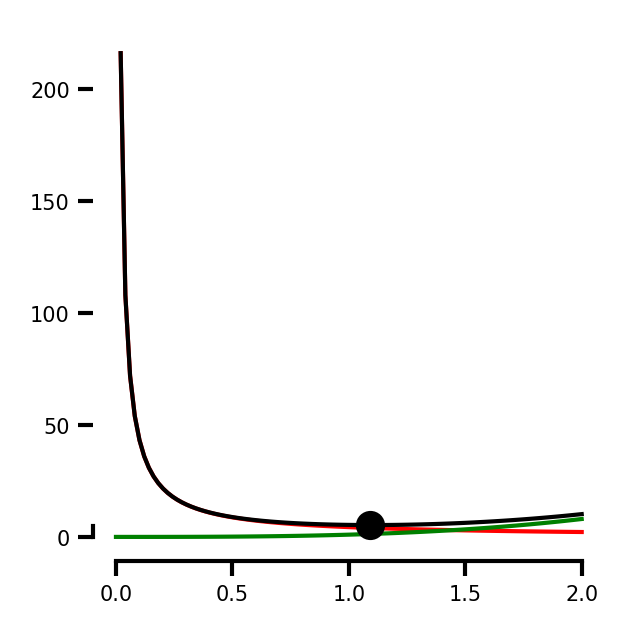

In [ ]:
import matplotlib.animation as animation

fig, ax = plt.subplots(figsize=(2, 2))
ax.set_xlabel('Crossing duration (s)')
ax.set_ylabel('Cost (a.u.)')
ax.legend()


D_values = np.arange(0.5, 2.1, 0.01)  # Values of D to animate

def plot_model(D, vbelt=0, alpha=1, beta=1, power_effort=2, power_time=3):
    T = np.linspace(0, 2, 100)
    ax.clear()
    ax.plot(T, effort_cost(T, D, alpha, vbelt, power_effort), label=r'$C_v$', color='r')
    ax.plot(T, time_cost(T, beta, power_time), label=r'$C_t$', color='g')
    ax.plot(T, effort_cost(T, D, alpha, vbelt, power_effort) + time_cost(T, beta, power_time), label=r'$C_v + C_t$', color='k')
    # argmin of total cost
    ax.plot(T[np.nanargmin(effort_cost(T, D, alpha, vbelt, power_effort) + time_cost(T, beta, power_time))], 
            np.nanmin(effort_cost(T, D, alpha, vbelt, power_effort) + time_cost(T, beta, power_time)),
            'o', color='k')#, label=r'$T^*$')

    ax.set_ylim(-.5, 5)
    ax.set_xlim(-.25, 2.25)
    ax.spines['left'].set_bounds(0, 5)
    ax.spines['bottom'].set_bounds(0, 2)


# Function to update the scatter plot
def update(frame):
    plot_model(D_values[frame])
    # scat.set_offsets((D_values[frame], 0))
    # return scat,

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(D_values), repeat=True, interval=500)

# To save the animation using Pillow as a gif
writer = animation.PillowWriter(fps=10, metadata=dict(artist='Me'), bitrate=180)
ani.save('/home/david/Desktop/code/parameter_animation.gif', writer=writer, dpi=300)

plt.show()


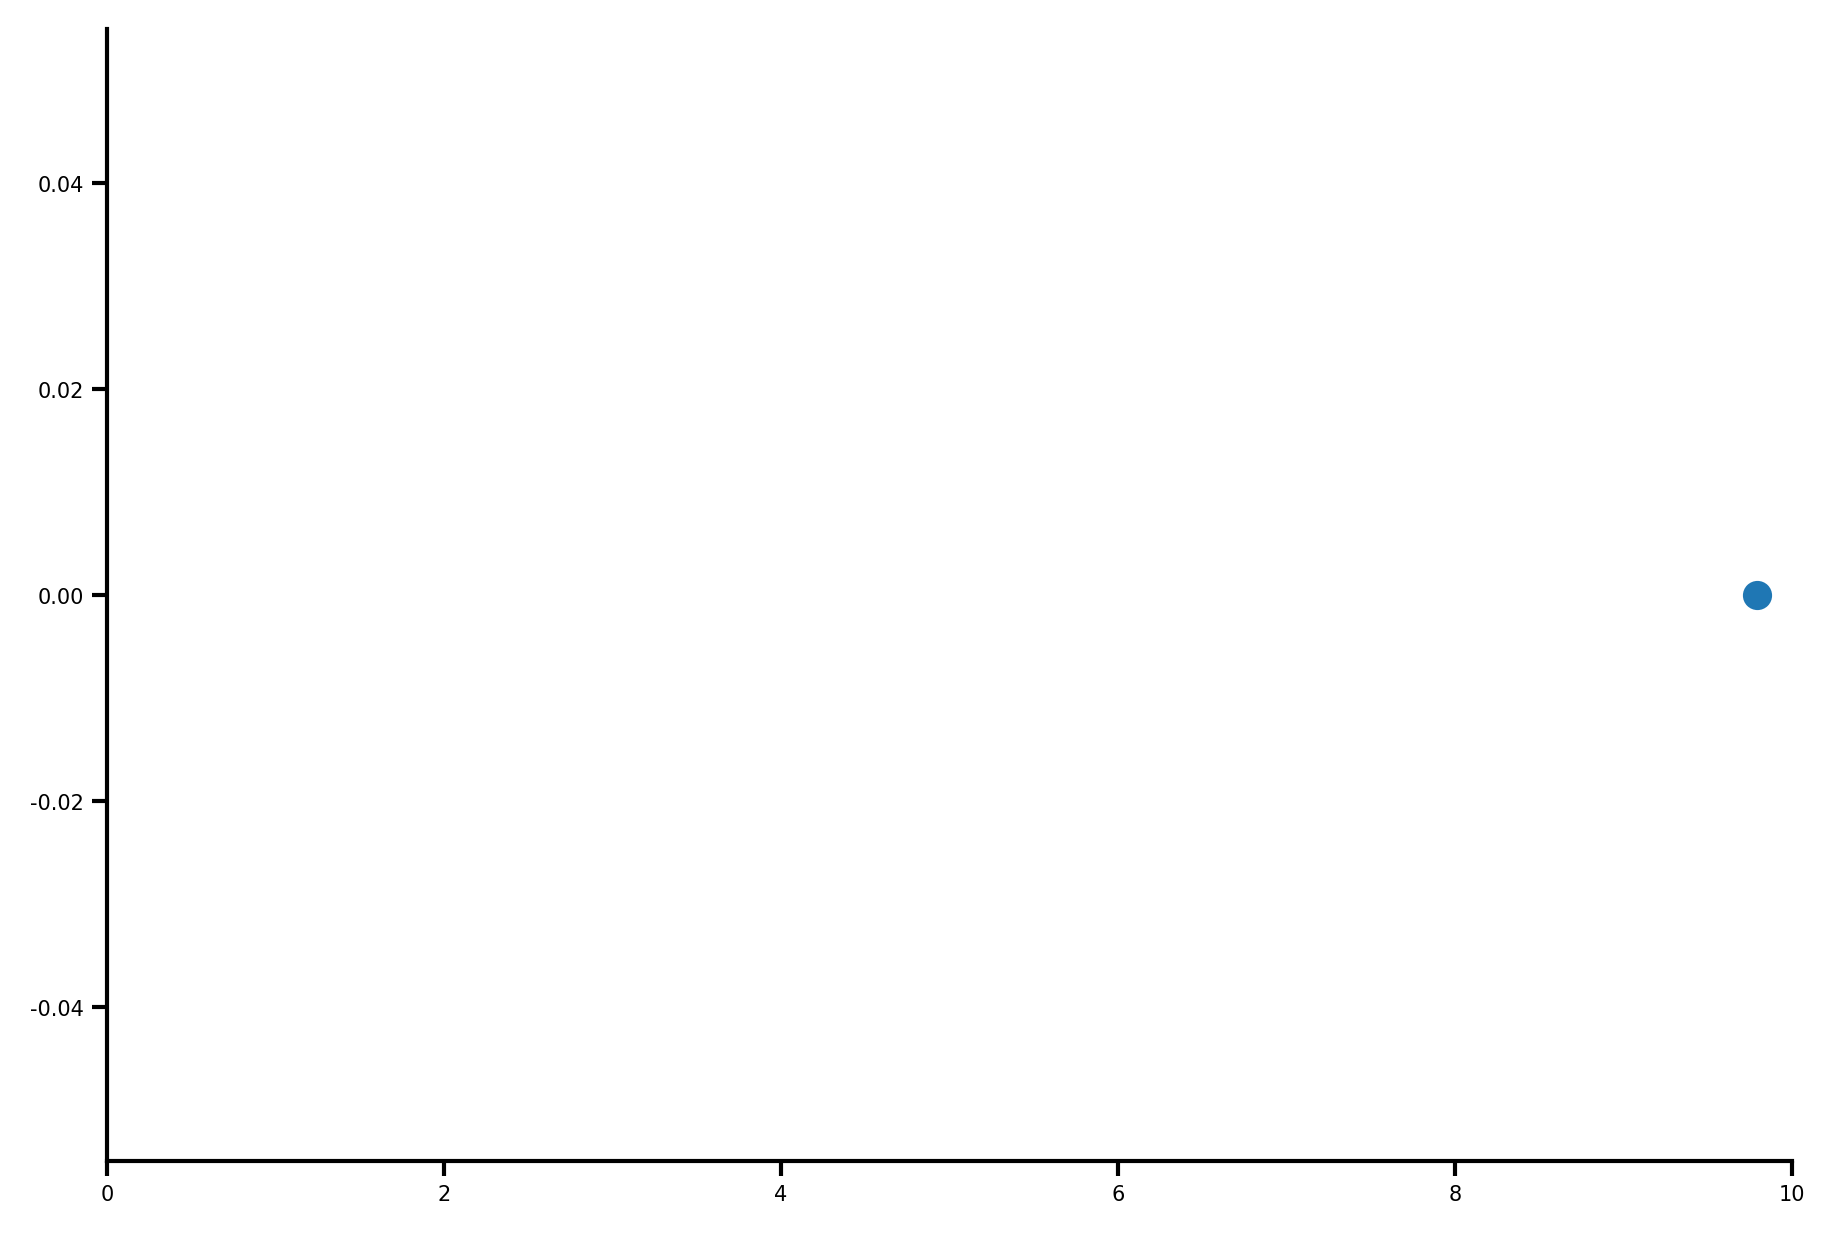

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation

fig, ax = plt.subplots()
ax.set_xlim([0, 10])

scat = ax.scatter(1, 0)
x = np.linspace(0, 10)


def animate(i):
    scat.set_offsets((x[i], 0))
    return scat,

ani = animation.FuncAnimation(fig, animate, repeat=True,
                                    frames=len(x) - 1, interval=50)

# To save the animation using Pillow as a gif
writer = animation.PillowWriter(fps=15,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
ani.save('/home/david/Desktop/code/scatter.gif', writer=writer)

plt.show()

In [ ]:
X = np.linspace(-np.pi, np.pi, 256, endpoint=True)
C, S = np.cos(X), np.sin(X)

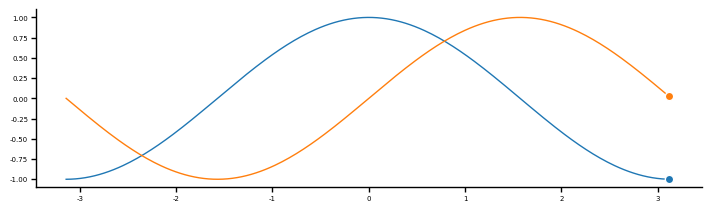

In [ ]:
import matplotlib.animation as animation

fig = plt.figure(figsize=(7,2), dpi=100)
ax = plt.subplot()

line1, = ax.plot(X, C, marker="o", markevery=[-1], markeredgecolor="white")
line2, = ax.plot(X, S, marker="o", markevery=[-1], markeredgecolor="white")

def update(frame):
    line1.set_data(X[:frame], C[:frame])
    line2.set_data(X[:frame], S[:frame])

writer = animation.FFMpegWriter(fps=30)
anim = animation.FuncAnimation(fig, update, interval=10, frames=len(X));
anim.save("../data/sine-cosine.mp4", writer=writer, dpi=100);

ani.save('/home/david/Desktop/code/scatter.gif', writer=writer)
plt.show();

/home/david/.local/lib/python3.7/site-packages/ipykernel_launcher.py:40: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
/home/david/.local/lib/python3.7/site-packages/IPython/core/pylabtools.py:137: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


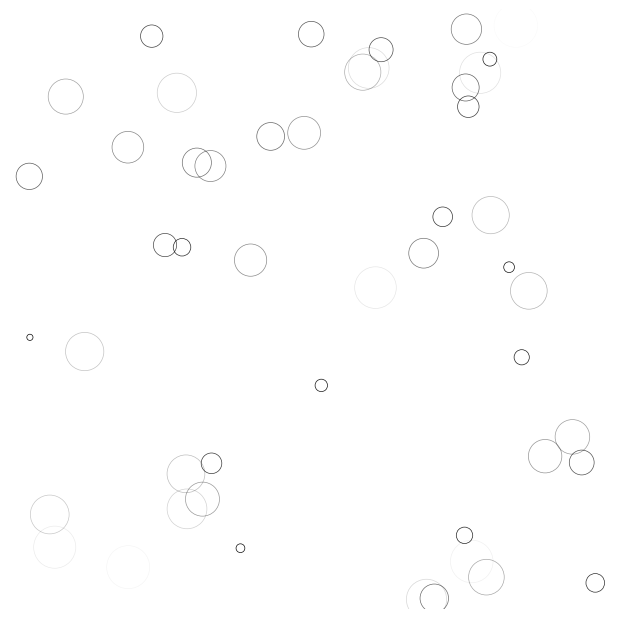

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def rain_update(frame):
    global R, scatter

    R["color"][:,3] = np.maximum(0, R["color"][:,3] - 1/len(R))
    R["size"] += 1/len(R)

    i = frame % len(R)
    R["position"][i] = np.random.uniform(0,1,2)
    R["size"][i] = 0
    R["color"][i,3] = 1
    
    scatter.set_edgecolors(R["color"])
    scatter.set_sizes(1000*R["size"].ravel())
    scatter.set_offsets(R["position"])
    
fig = plt.figure(figsize=(6,6), facecolor='white', dpi=100)
ax = fig.add_axes([0,0,1,1], frameon=False, aspect=1)
ax.set_xlim(0,1)
ax.set_xticks([])
ax.set_ylim(0,1)
ax.set_yticks([])
scatter = ax.scatter([], [], s=[], linewidth=0.5, edgecolors=[], facecolors="None")

n = 50
R = np.zeros(n, dtype=[ ("position", float, (2,)),
                        ("size",     float, (1,)),
                        ("color",    float, (4,)) ])                       
R["position"] = np.random.uniform(0, 1, (n,2))
R["size"] = np.linspace(0, 1, n).reshape(n,1)
R["color"][:,3] = np.linspace(0, 1, n)

ani = animation.FuncAnimation(fig, rain_update, interval=10, frames=200);
writer = animation.PillowWriter(fps=15,
                                metadata=dict(artist='Me'),
                                bitrate=1800)
ani.save('/home/david/Desktop/code/scatter.gif', writer=writer)

# suppl

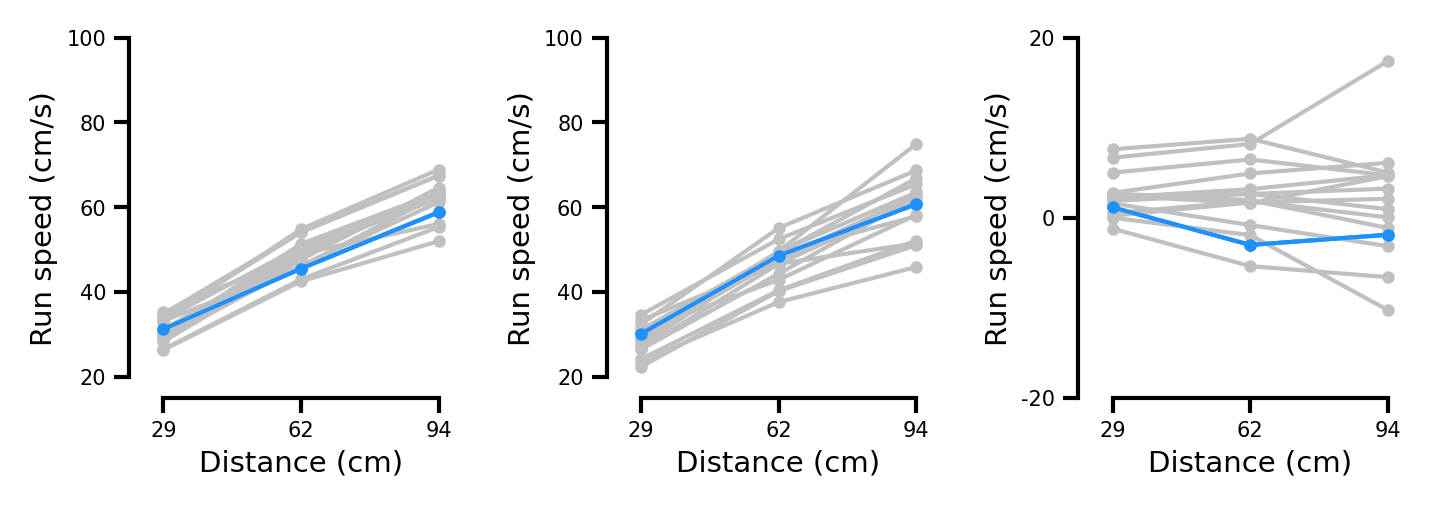

In [ ]:
def FigureS2I(axs=None):
    if axs is None:
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    conds = ["60", "90", "120"]
    run_speeds90 = {k: {a: [] for a in animalList} for k in conds}
    run_speeds10 = {k: {a: [] for a in animalList} for k in conds}

    for cond, sessionlist in zip(conds, [dist60, dist90, dist120]):
        for animal in animalList:
            for session in matchsession(animal, sessionlist):
                params = get_from_pickle(root, animal, session, name="params.p")
                for elem in sequence[animal, session]:
                    if sequence[animal, session][elem][1] == 'run':
                        tm_speed = params['treadmillSpeed'][get_block(sequence[animal, session][elem][0])]
                        if get_block(sequence[animal, session][elem][0]) %2 == 0:
                            run_speeds90[cond][animal].append(abs(sequence[animal, session][elem][-1]) - tm_speed)
                        else:
                            run_speeds10[cond][animal].append(abs(sequence[animal, session][elem][-1]) - tm_speed)


    for animal in animalList:
        axs[0].plot([0, 1, 2], [np.median(run_speeds90[cond][animal]) for cond in conds], color=rat_markers[animal][0],
                marker=rat_markers[animal][1], markersize=2)
        axs[1].plot([0, 1, 2], [np.median(run_speeds10[cond][animal]) for cond in conds], color=rat_markers[animal][0],
                marker=rat_markers[animal][1], markersize=2)

        axs[2].plot([0, 1, 2], [np.median(run_speeds90[cond][animal]) - np.median(run_speeds10[cond][animal]) for cond in conds], color=rat_markers[animal][0],
                marker=rat_markers[animal][1], markersize=2)

        if animal == "RatM00":
            axs[0].plot([0, 1, 2], [np.median(run_speeds90[cond][animal]) for cond in conds], color=rat_markers[animal][0],
                    marker=rat_markers[animal][1], markersize=2, zorder=10)
            axs[1].plot([0, 1, 2], [np.median(run_speeds10[cond][animal]) for cond in conds], color=rat_markers[animal][0],
                    marker=rat_markers[animal][1], markersize=2, zorder=10)
            
            axs[2].plot([0, 1, 2], [np.median(run_speeds90[cond][animal]) - np.median(run_speeds10[cond][animal]) for cond in conds], color=rat_markers[animal][0],
                    marker=rat_markers[animal][1], markersize=2, zorder=10)



    # animal='RatF02'
    # session='RatF02_2021_07_22_18_14_16'
    # example_session_run_speeds = []
    # params = get_from_pickle(root, animal, session, name="params.p")
    # for elem in sequence[animal, session]:
    #     if sequence[animal, session][elem][1] == 'run':
    #         tm_speed = params['treadmillSpeed'][get_block(sequence[animal, session][elem][0])]
    #         example_session_run_speeds.append(abs(sequence[animal, session][elem][-1]) - tm_speed)

    # ax.plot(2, np.median(example_session_run_speeds), color='black', marker='^', zorder=10, markersize=2, linewidth=0)

    for ax in axs:
        ax.set_xlim(-0.25, 2.25)
        ax.set_xticks([0, 1, 2])
        ax.set_xticklabels(["29", "62", "94"])
        ax.set_xlabel("Distance (cm)")


        ax.set_ylim(15, 100)
        ax.set_yticks([20, 40, 60, 80, 100])
        ax.set_ylabel("Run speed (cm/s)")


        ax.spines['left'].set_bounds(20, 100)
        ax.spines['bottom'].set_bounds(0, 2)

    axs[2].set_ylim(-20, 20)
    axs[2].spines['left'].set_bounds(-20, 20)
    axs[2].set_yticks([-20, 00, 20])

fig, axs = plt.subplots(1, 3, figsize=(cm2inch(12), cm2inch(4)))
FigureS2I(axs=axs)

[39.58839798912963, 56.94630658669116, 74.03565885278887]


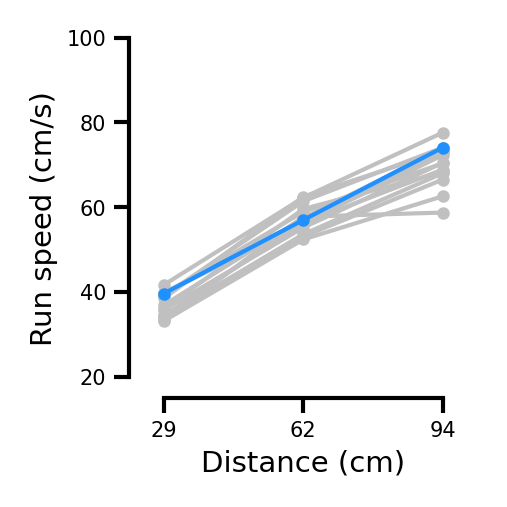

In [ ]:
def Figure2I(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    conds = ["60", "90", "120"]
    run_speeds = {k: {a: [] for a in animalList} for k in conds}

    for cond, sessionlist in zip(conds, [dist60, dist90, dist120]):
        for animal in animalList:
            for session in matchsession(animal, sessionlist):
                params = get_from_pickle(root, animal, session, name="params.p")
                for elem in sequence[animal, session]:
                    if get_block(sequence[animal, session][elem][0]) == 0:

                        if sequence[animal, session][elem][1] == 'run':
                            tm_speed = params['treadmillSpeed'][get_block(sequence[animal, session][elem][0])]
                            run_speeds[cond][animal].append(abs(sequence[animal, session][elem][-1]) - tm_speed)


    for animal in animalList:
        ax.plot([0, 1, 2], [np.median(run_speeds[cond][animal]) for cond in conds], color=rat_markers[animal][0],
                marker=rat_markers[animal][1], markersize=2)

        if animal == "RatM00":
            print([np.median(run_speeds[cond][animal]) for cond in conds])
            ax.plot([0, 1, 2], [np.median(run_speeds[cond][animal]) for cond in conds], color=rat_markers[animal][0],
                    marker=rat_markers[animal][1], markersize=2, zorder=10)


    ax.set_xlim(-0.25, 2.25)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(["29", "62", "94"])
    ax.set_xlabel("Distance (cm)")


    ax.set_ylim(15, 100)
    ax.set_yticks([20, 40, 60, 80, 100])
    ax.set_ylabel("Run speed (cm/s)")


    ax.spines['left'].set_bounds(20, 100)
    ax.spines['bottom'].set_bounds(0, 2)

fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure2I(ax=ax)